# Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import torch
import tqdm.auto as tqdm
%matplotlib widget

In [2]:
# we want bootstrap() from utils
import sys
sys.path.append('..')
from util import *

In [3]:
def grab(x):
    return x.detach().numpy()

# HMC

Copied from the lecture implementation.

In [4]:
class Phi4Action:
    def __init__(self, m2, lam):
        self.m2 = m2
        self.lam = lam
        self.grad = torch.func.grad(self.value)
    def value(self, phi):
        # phi.shape = (Lx, Ly, ...)
        Nd = len(phi.shape)
        S = ((Nd + self.m2/2) * phi**2 + (self.lam/24) * phi**4).sum()
        for mu in range(Nd):
            phi_fwd = torch.roll(phi, -1, dims=mu)
            S -= (phi * phi_fwd).sum()
        return S

In [5]:
def leapfrog_update(phi, pi, action, *, dt, n_leap):
    phi += (dt/2)*pi
    for _ in range(n_leap-1):
        pi -= dt*action.grad(phi)
        phi += dt*pi
    pi -= dt*action.grad(phi)
    phi += (dt/2)*pi

Modified from the lecture to allow setting arbitrary L, remove fixed seed.

In [6]:
def run_hmc(action, *, L, n_therm, n_iter, n_meas, dt=0.10, n_leap=10):
    phi = 0.1*torch.randn((L, L)) # warm start
    S = action.value(phi)
    acc = 0
    tot = 0
    meas = []
    for i in range(-n_therm, n_iter):
        new_phi = phi.clone()
        pi = torch.randn_like(phi)
        K = (pi**2/2).sum()
        leapfrog_update(new_phi, pi, action, dt=dt, n_leap=n_leap)
        Sp = action.value(new_phi)
        Kp = (pi**2/2).sum()
        dH = grab(Sp + Kp - S - K)
        tot += 1
        if np.random.random() < np.exp(-dH): # accept
            phi = new_phi
            S = Sp
            acc += 1
        if i >= 0 and (i+1)%n_meas == 0:
            meas.append(grab(phi.mean()))
            # print(f'Acc {100.0*acc/tot:.2f}')
    return dict(meas=np.stack(meas))

Let's generate some data at various lattice spacings for the free theory. Since the mass does not renormalize in the free theory, we can do so by fixing $m_0 L = 4$ in terms of the bare mass.

In [7]:
Ls = np.array([6, 8, 10, 12, 14, 16])
ms = 4/Ls
results = []
for m, L in zip(ms, Ls):
    # we run 10 chains to help estimate errors on tint
    all_phi_bar = []
    for i in tqdm.tqdm(range(10)):
        all_phi_bar.append(run_hmc(
            Phi4Action(m**2, 0.0), L=L, n_therm=100, n_iter=1000, n_meas=1, dt=0.05, n_leap=20)['meas'])
    results.append(np.stack(all_phi_bar))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

# Autocorrelations

In [8]:
def tint(O, tmax):
    """
    Measure integrated autocorrelation time using measured values of O(phi) over n Markov chains.
    Using multiple Markov chains allows error estimation. We assume that <O> = 0.
    """
    n_chain, n_step = O.shape
    print(f'{O.shape=}')
    Gamma = []
    for Oi in O:
        Gamma.append(np.stack([np.mean(Oi**2)] + [np.mean(Oi[t:] * Oi[:-t]) for t in range(1,tmax)]))
    Gamma = np.stack(Gamma)
    # this function actually evaluates tint from Gamma resampled over the Markov chains
    def est_tint(boot_Gamma):
        Gamma = np.mean(boot_Gamma, axis=0)
        Gamma /= Gamma[0]
        # calculated this way so that the first point (which is always = 1) contributes 0.5 per the defn
        return np.cumsum(Gamma[:tmax]) - 0.5
    tint_mean_var = bootstrap(Gamma, Nboot=1000, f=est_tint)
    return np.arange(tmax), tint_mean_var

In [9]:
all_tint = [tint(res, tmax=250) for res in results]

O.shape=(10, 1000)
O.shape=(10, 1000)
O.shape=(10, 1000)
O.shape=(10, 1000)
O.shape=(10, 1000)
O.shape=(10, 1000)


ts.shape=(250,) tint[0].shape=(250,)
ts.shape=(250,) tint[0].shape=(250,)
ts.shape=(250,) tint[0].shape=(250,)
ts.shape=(250,) tint[0].shape=(250,)
ts.shape=(250,) tint[0].shape=(250,)
ts.shape=(250,) tint[0].shape=(250,)


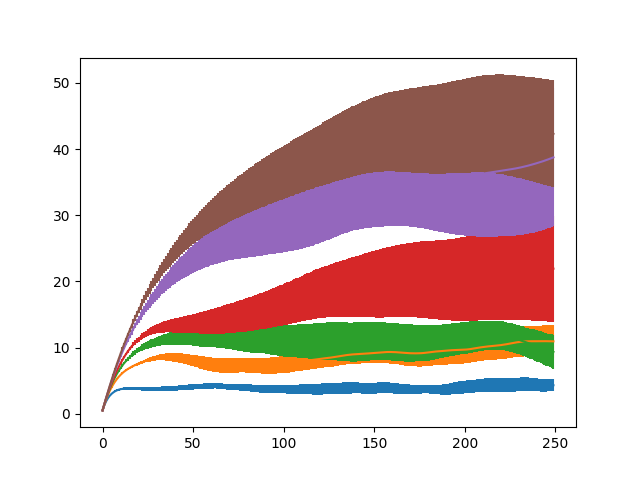

In [10]:
fig, ax = plt.subplots(1,1)
for ts, tint in all_tint:
    print(f'{ts.shape=} {tint[0].shape=}')
    ax.errorbar(ts, tint[0], yerr=tint[1])
plt.show()

Ordinarily, one would come up with a consistent scheme to truncate the $\tau_{\mathrm{int}}$ integrals. For this crude analysis, we choose a plateau value by eye.

In [11]:
tint_plateaus = [10, 25, 30, 50, 90, 120]
tint_values = []
for plat, (ts, tint) in zip(tint_plateaus, all_tint):
    # (mean, err)
    tint_values.append((tint[0][plat], tint[1][plat]))
tint_values = np.stack(tint_values, axis=1)

In [12]:
# fit to a power law
def fit_f(a, A, z):
    return A * a**(-z)
popt, _ = sp.optimize.curve_fit(fit_f, 1/Ls, tint_values[0], sigma=tint_values[1])

In [13]:
print(popt)

[0.08123388 2.16356118]


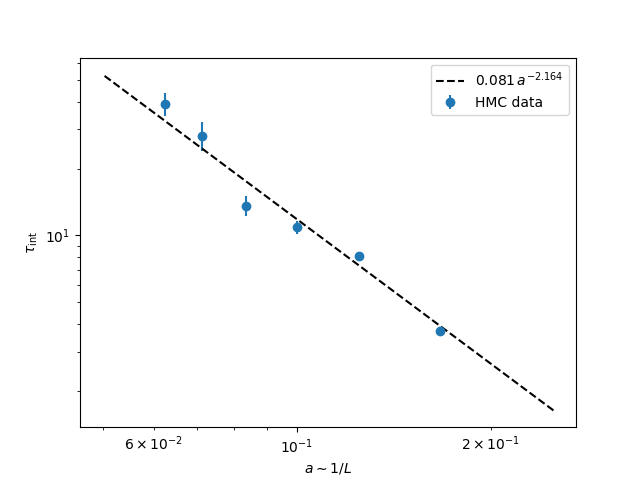

In [14]:
fig, ax = plt.subplots(1,1)
ax.errorbar(
    1/Ls, tint_values[0], yerr=tint_values[1], marker='o', linestyle='',
    label='HMC data'
)
plot_L = np.linspace(4, 20)
plot_a = 1/plot_L
ax.plot(
    plot_a, fit_f(plot_a, *popt), color='k', linestyle='--',
    label=rf'${popt[0]:.3f} \, a^{{-{popt[1]:.3f}}}$'
)
ax.legend()
ax.set_xlabel(r'$a \sim 1/L$')
ax.set_ylabel(r'$\tau_{\mathrm{int}}$')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()